In [1]:
# 기본 라이브러리 임포트
import pandas as pd             
import numpy as np             
import matplotlib.pyplot as plt 
import seaborn as sns           
import gc                       # 가비지 컬렉션(메모리 해제)
import re                       # 정규 표현식 처리
from collections import defaultdict  # 기본값이 있는 딕셔너리 생성

# 경고 메시지 억제
import warnings
warnings.filterwarnings('ignore')   

# 그래프 스타일 설정
sns.set()                           # seaborn 기본 스타일 적용

# matplotlib 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 한글 폰트 설정
# plt.rcParams['font.family'] = 'AppleGothic'  
plt.rcParams['figure.figsize'] = (12, 6)       # 그림 크기 설정 (가로, 세로)
plt.rcParams['font.size'] = 14                 # 폰트 크기 설정
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지

# 결측치 시각화 라이브러리 임포트
import missingno                          # 결측치 분포를 시각화하는 유틸리티

# 범주형 변수 레이블 인코딩을 위한 도구 임포트
from sklearn.preprocessing import LabelEncoder

# 중복 조합 생성에 사용할 product 함수 임포트
from itertools import product

# 회귀 및 통계 분석을 위한 statsmodels 임포트
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler

In [2]:
# features_importances CSV 파일 불러오기
df = pd.read_csv('병합_selected_features.csv')

# df1 Parquet 파일 불러오기
df1 = pd.read_parquet('open/concat/2018_채널정보.parquet')

# Segment 정보 추출용
segment_df = df[['ID', 'Segment']]

# df 컬럼 리스트와, 추가로 뽑아낼 ARS·PC·앱 컬럼 리스트 정의
cols_df = df.columns.tolist()
selected_cols = [
    '인입횟수_ARS_R6M',
    '이용메뉴건수_ARS_R6M',
    '방문횟수_PC_R6M',
    '방문일수_PC_R6M',
    '방문횟수_앱_R6M'
]

# df1에서 df에 있는 컬럼 혹은 selected_cols에 포함된 컬럼만 골라 common_cols 생성
common_cols = [
    col
    for col in df1.columns
    if col in cols_df or col in selected_cols
]

# ID가 common_cols에 없다면 추가
if 'ID' not in common_cols:
    common_cols.insert(0, 'ID')

# 공통·추가 컬럼만 추출하여 df2 생성
df2 = df1[common_cols]

# Segment 병합
df2 = df2.merge(segment_df, on='ID', how='left')

# 결과 확인
display(df2)

,ID,인입횟수_ARS_R6M,이용메뉴건수_ARS_R6M,이용메뉴건수_ARS_B0M,방문횟수_PC_R6M,방문일수_PC_R6M,방문횟수_앱_R6M,상담건수_B0M,불만제기후경과월_R12M,당사멤버쉽_방문횟수_B0M,당사멤버쉽_방문횟수_R6M,Segment
0,TRAIN_000000,10회 이상,10회 이상,6,1회 이상,1회 이상,1회 이상,0,12,22,221,D
1,TRAIN_000001,1회 이상,1회 이상,0,1회 이상,1회 이상,1회 이상,0,12,0,0,E
2,TRAIN_000002,1회 이상,1회 이상,5,10회 이상,10회 이상,30회 이상,2,12,0,0,C
3,TRAIN_000003,10회 이상,10회 이상,6,1회 이상,1회 이상,1회 이상,0,12,23,219,D
4,TRAIN_000004,1회 이상,1회 이상,0,1회 이상,1회 이상,1회 이상,0,0,0,0,E
...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,TEST_99995,1회 이상,1회 이상,0,1회 이상,1회 이상,1회 이상,0,0,0,0,NaN
2999996,TEST_99996,1회 이상,1회 이상,0,1회 이상,1회 이상,10회 이상,0,12,0,0,NaN
2999997,TEST_99997,1회 이상,1회 이상,0,1회 이상,1회 이상,1회 이상,0,0,0,0,NaN
2999998,TEST_99998,1회 이상,1회 이상,0,1회 이상,1회 이상,40회 이상,0,12,0,0,NaN


In [3]:
df2.dtypes

ID                object
인입횟수_ARS_R6M      object
이용메뉴건수_ARS_R6M    object
이용메뉴건수_ARS_B0M     int64
방문횟수_PC_R6M       object
방문일수_PC_R6M       object
방문횟수_앱_R6M        object
상담건수_B0M           int64
불만제기후경과월_R12M      int64
당사멤버쉽_방문횟수_B0M     int64
당사멤버쉽_방문횟수_R6M     int64
Segment           object
dtype: object

In [4]:
# object 타입 컬럼(ID·Segment 제외)
object_cols = [
    col
    for col in df2.select_dtypes(include=['object']).columns
    if col not in ['ID', 'Segment']
]

# 각 object 컬럼 숫자만 추출해 float으로 변환
for col in object_cols:
    df2[col] = (
        df2[col]
        .astype(str)
        .str.extract(r'(\d+)')[0]
        .astype(float)
    )

# 변환된 컬럼별 분포 출력
for col in object_cols:
    print(f"--- {col} (dtype={df2[col].dtype}) ---")
    print(df2[col].value_counts(dropna=False).sort_index())

--- 인입횟수_ARS_R6M (dtype=float64) ---
인입횟수_ARS_R6M
1.0     2910377
10.0      89623
Name: count, dtype: int64
--- 이용메뉴건수_ARS_R6M (dtype=float64) ---
이용메뉴건수_ARS_R6M
1.0     2891465
10.0      88221
20.0       7488
30.0      12826
Name: count, dtype: int64
--- 방문횟수_PC_R6M (dtype=float64) ---
방문횟수_PC_R6M
1.0     2777565
10.0      83962
20.0      96590
30.0      40813
40.0       1070
Name: count, dtype: int64
--- 방문일수_PC_R6M (dtype=float64) ---
방문일수_PC_R6M
1.0     2796530
10.0     128458
20.0      72485
30.0       2527
Name: count, dtype: int64
--- 방문횟수_앱_R6M (dtype=float64) ---
방문횟수_앱_R6M
1.0     2603931
10.0     117440
20.0      78975
30.0      66722
40.0      55460
50.0      39208
60.0      27680
70.0      10195
80.0        389
Name: count, dtype: int64


In [5]:
# 모든 행·열 보이기
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

# 세그먼트별 요약 통계 계산
agg_stats = (
    df2
    .groupby('Segment')[object_cols]
    .agg(['mean', 'median', 'std', 'min', 'max'])
    .round(2)
)

# 전체 결과 출력
display(agg_stats)

인입횟수_ARS_R6M                         이용메뉴건수_ARS_R6M                         방문횟수_PC_R6M                          방문일수_PC_R6M                         방문횟수_앱_R6M                         
                mean median   std  min   max           mean median   std  min   max        mean median    std  min   max        mean median   std  min   max       mean median    std  min   max
Segment                                                                                                                                                                                         
A               1.69    1.0  2.40  1.0  10.0           2.03    1.0  3.90  1.0  30.0        5.12    1.0   8.05  1.0  40.0        3.74    1.0  5.63  1.0  30.0       6.05    1.0  13.73  1.0  70.0
B               2.88    1.0  3.67  1.0  10.0           3.51    1.0  6.06  1.0  30.0        7.40    1.0  10.07  1.0  40.0        5.35    1.0  7.14  1.0  20.0      21.12    5.5  24.96  1.0  70.0
C               1.74    1.0  2.48  1.0  10.0           2.11    1.0  4.10  1.0  30.0        4.29    1.0   7.54  1.0  40.0        3.23    1.0  5.31  1.0  30.0       8.38    1.0  15.91  1.0  80.0
D               1.54    1.0  2.14  1.0  10.0           1.85    1.0  3.59  1.0  30.0        3.31    1.0   6.46  1.0  40.0        2.58    1.0  4.56  1.0  30.0       7.78    1.0  15.08  1.0  80.0
E               1.18    1.0  1.28  1.0  10.0           1.31    1.0  2.18  1.0  30.0        1.95    1.0   4.29  1.0  40.0        1.65    1.0  3.04  1.0  30.0       3.84    1.0   9.85  1.0  80.0

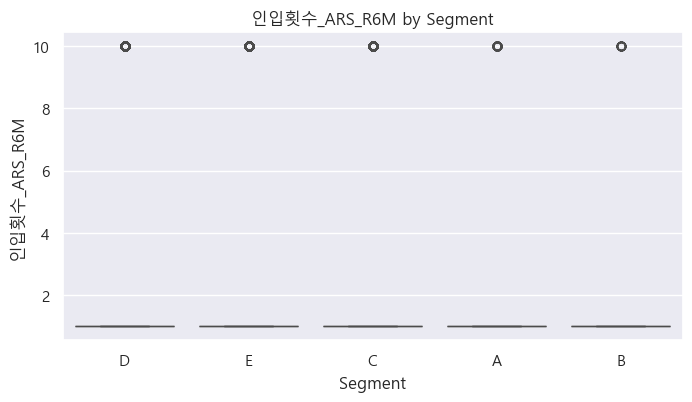

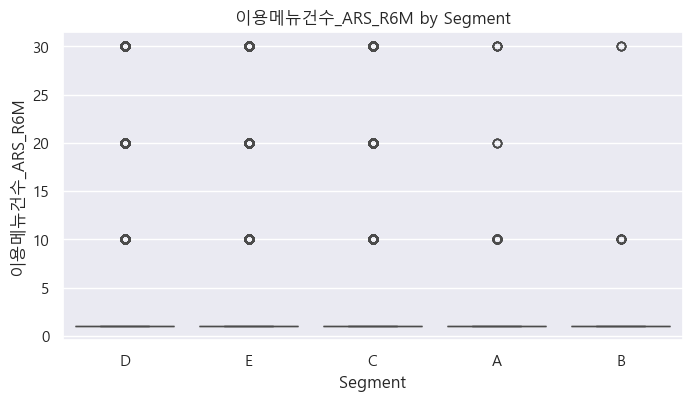

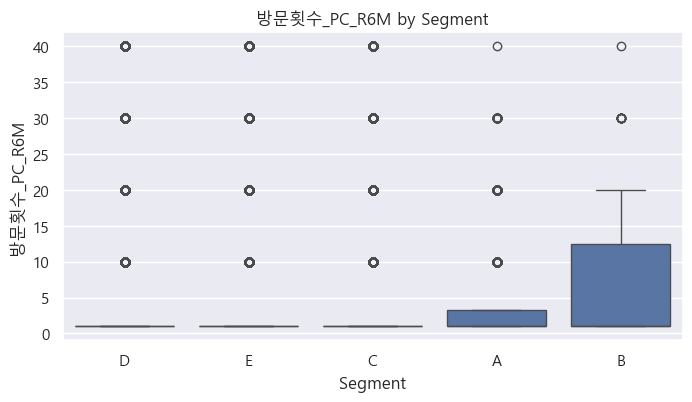

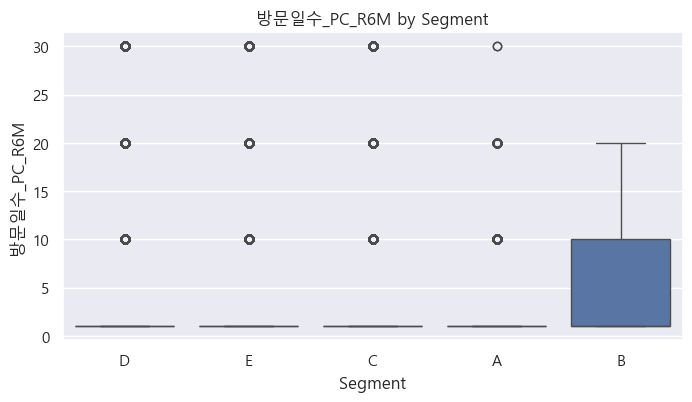

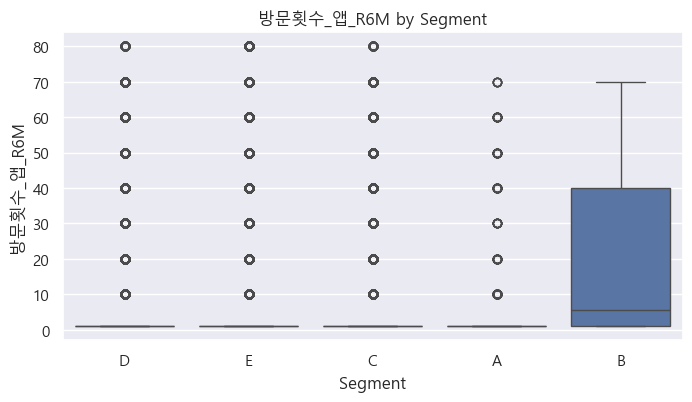

In [6]:
for col in object_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='Segment', y=col, data=df2)
    plt.title(f'{col} by Segment')
    plt.show()

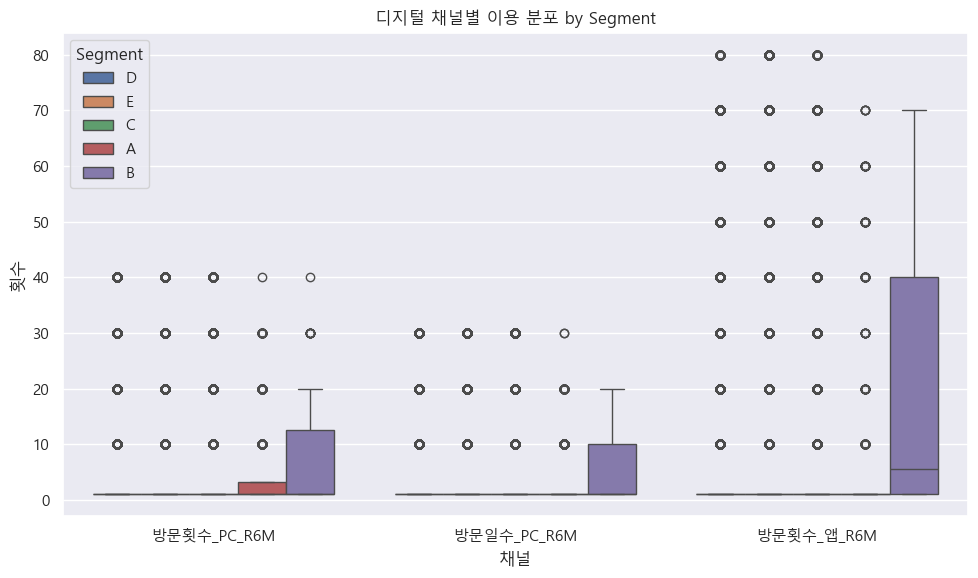

In [7]:
# 분석할 컬럼과 세그먼트만 선택
cols = ['방문횟수_PC_R6M', '방문일수_PC_R6M', '방문횟수_앱_R6M', 'Segment']
df_long = (
    df2[cols]
    .melt(id_vars='Segment', 
          value_vars=['방문횟수_PC_R6M', '방문일수_PC_R6M', '방문횟수_앱_R6M'],
          var_name='채널', 
          value_name='횟수')
)

# 박스플롯으로 한 번에 비교
plt.figure(figsize=(10,6))
sns.boxplot(x='채널', y='횟수', hue='Segment', data=df_long)
plt.title('디지털 채널별 이용 분포 by Segment')
plt.legend(title='Segment')
plt.tight_layout()
plt.show()

=== 세그먼트별 요약 통계 ===
        방문횟수_PC_R6M               방문일수_PC_R6M              방문횟수_앱_R6M              
               mean median    std        mean median   std       mean median    std
Segment                                                                            
A              5.12    1.0   8.05        3.74    1.0  5.63       6.05    1.0  13.73
B              7.40    1.0  10.07        5.35    1.0  7.14      21.12    5.5  24.96
C              4.29    1.0   7.54        3.23    1.0  5.31       8.38    1.0  15.91
D              3.31    1.0   6.46        2.58    1.0  4.56       7.78    1.0  15.08
E              1.95    1.0   4.29        1.65    1.0  3.04       3.84    1.0   9.85


<Figure size 600x400 with 0 Axes>

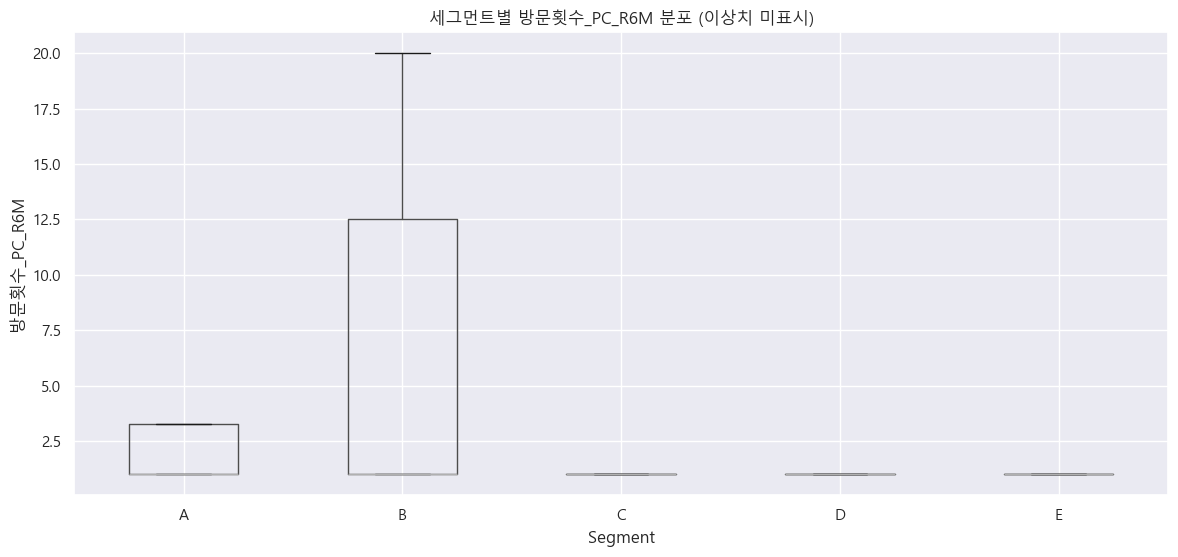

<Figure size 600x400 with 0 Axes>

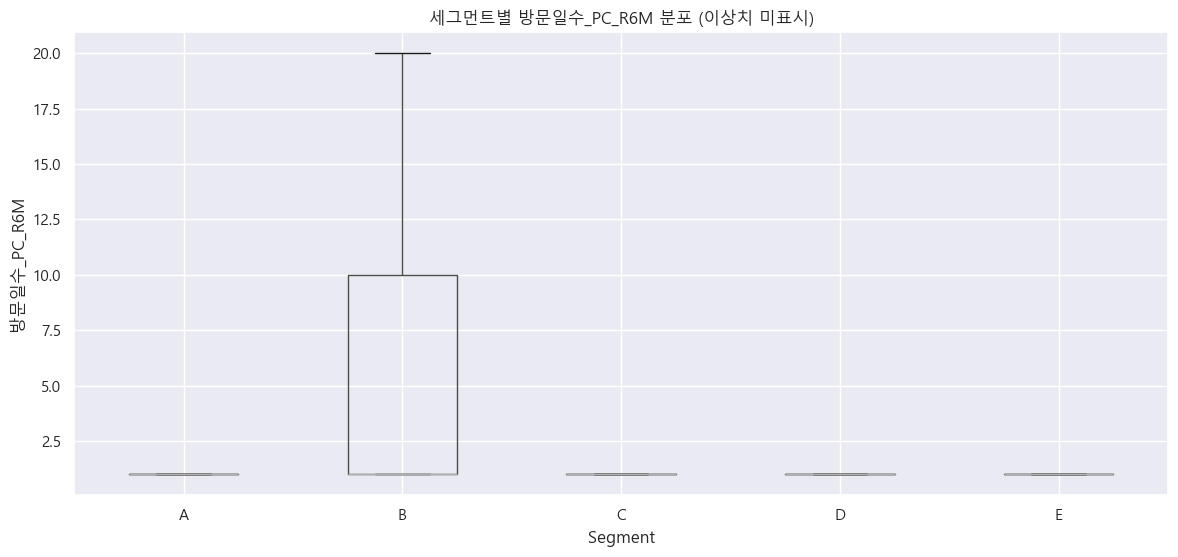

<Figure size 600x400 with 0 Axes>

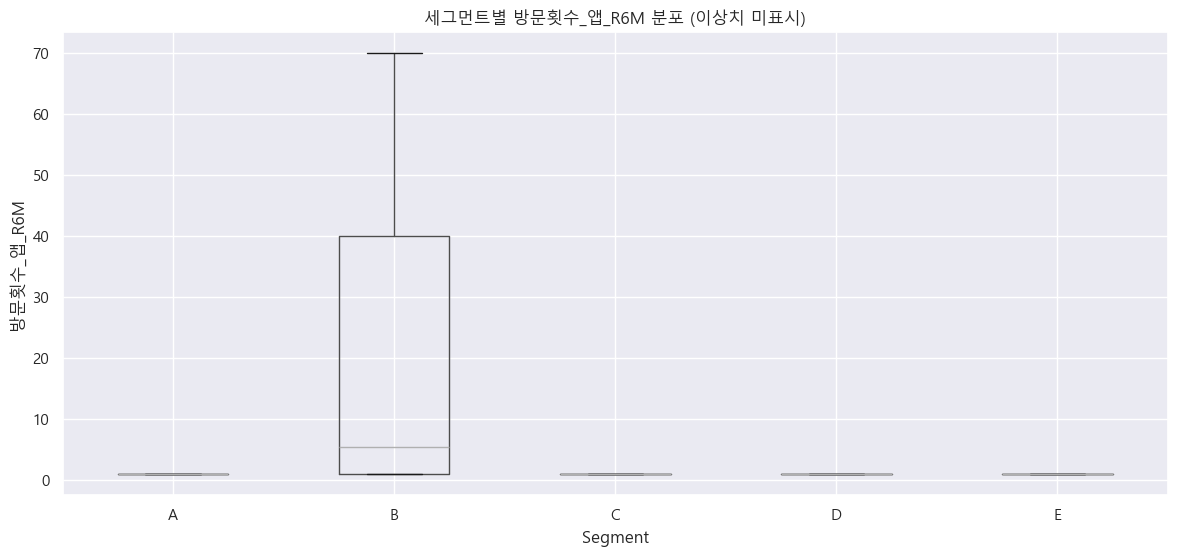

In [8]:
# 정의: 분석할 피처 리스트
features = ['방문횟수_PC_R6M', '방문일수_PC_R6M', '방문횟수_앱_R6M']

# 계산: 세그먼트별 요약 통계(평균·중앙값·표준편차) 구하기
stats = (
    df2
    .groupby('Segment')[features]
    .agg(['mean', 'median', 'std'])
    .round(2)
)
print("=== 세그먼트별 요약 통계 ===")
print(stats)

# 시각화: 이상치 미표시 박스플롯
for feat in features:
    plt.figure(figsize=(6, 4))
    # 계산: 박스플롯 (이상치 생략)
    df2.boxplot(
        column=feat,
        by='Segment',
        showfliers=False
    )
    plt.title(f'세그먼트별 {feat} 분포 (이상치 미표시)')
    plt.suptitle('')      # 기본 제목 제거
    plt.xlabel('Segment')
    plt.ylabel(feat)
    plt.tight_layout()
    plt.show()

=== 세그먼트별 로그변환 요약 통계 ===
        방문횟수_PC_R6M_log        방문일수_PC_R6M_log        방문횟수_앱_R6M_log       
                   mean median            mean median           mean median
Segment                                                                    
A                  1.23   0.69            1.12   0.69           1.12   0.69
B                  1.46   0.69            1.32   0.69           2.13   1.55
C                  1.11   0.69            1.03   0.69           1.32   0.69
D                  0.99   0.69            0.93   0.69           1.28   0.69
E                  0.81   0.69            0.79   0.69           0.96   0.69


<Figure size 600x400 with 0 Axes>

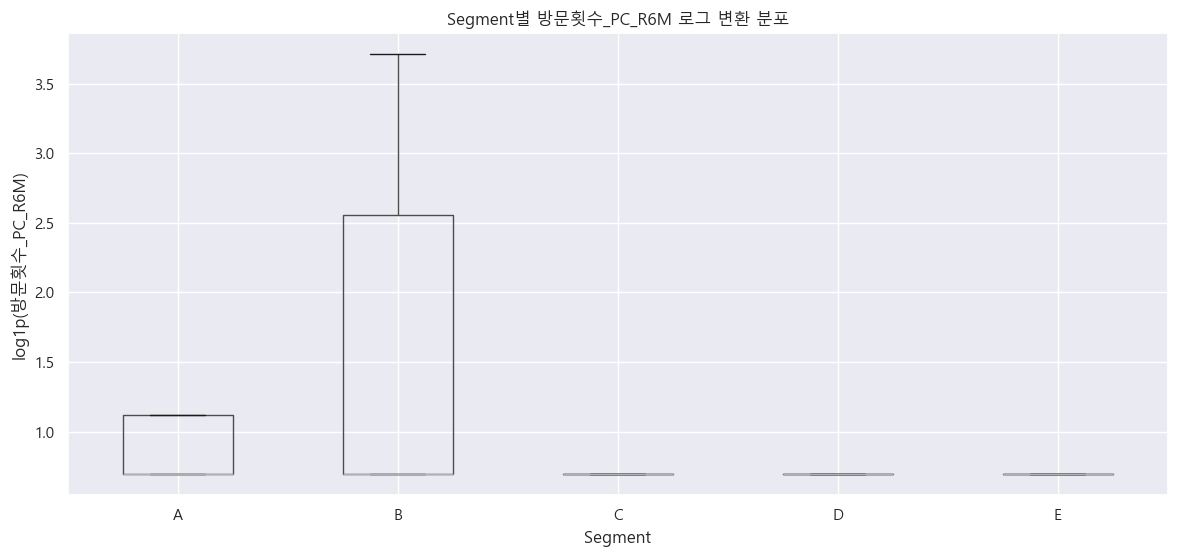

<Figure size 600x400 with 0 Axes>

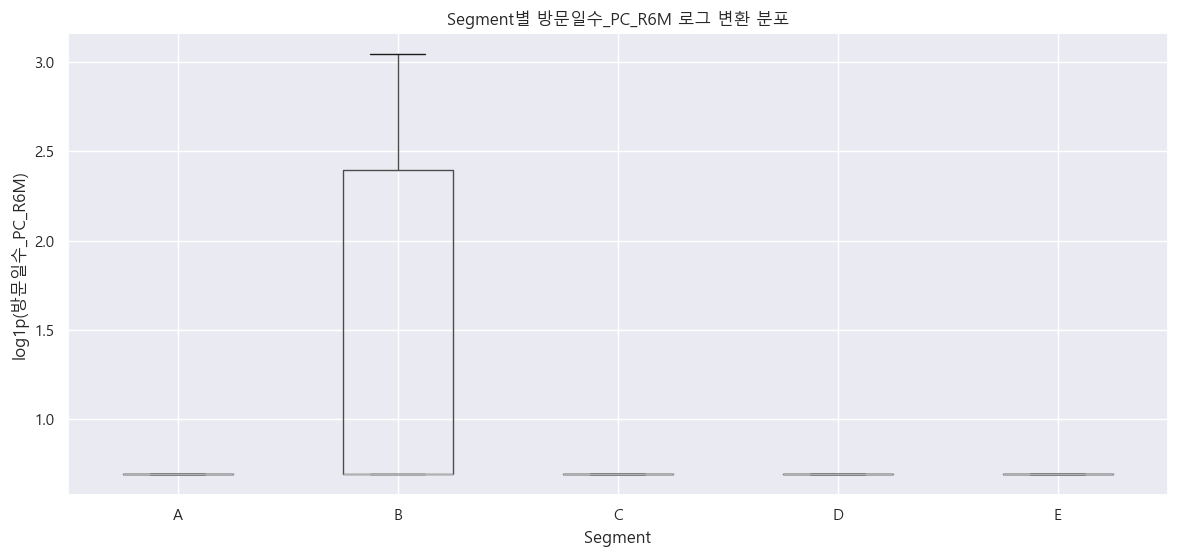

<Figure size 600x400 with 0 Axes>

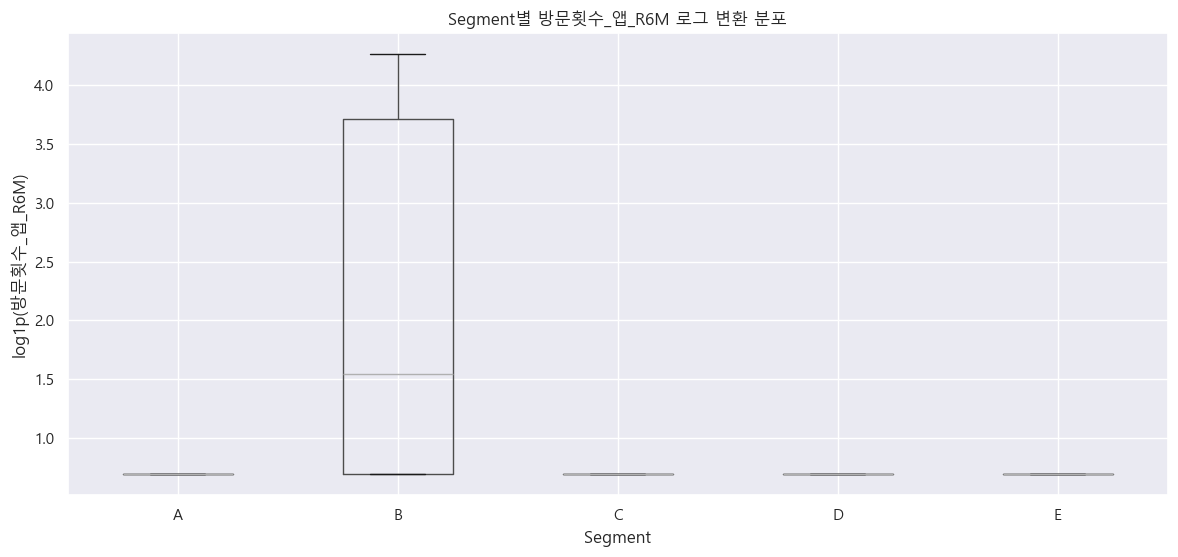

In [9]:
# 생성: 로그 변환 (1을 더한 후 자연로그)
log_cols = ['방문횟수_PC_R6M', '방문일수_PC_R6M', '방문횟수_앱_R6M']
for col in log_cols:
    df2[f'{col}_log'] = np.log1p(df2[col])

# 계산: 세그먼트별 로그값 요약 통계 (평균·중앙값)
stats_log = (
    df2
    .groupby('Segment')[[f'{c}_log' for c in log_cols]]
    .agg(['mean','median'])
    .round(2)
)
print("=== 세그먼트별 로그변환 요약 통계 ===")
print(stats_log)

# 시각화: 로그값 박스플롯 (이상치 미표시)
for col in log_cols:
    plt.figure(figsize=(6,4))
    df2.boxplot(
        column=f'{col}_log',
        by='Segment',
        showfliers=False
    )
    plt.title(f'Segment별 {col} 로그 변환 분포')
    plt.suptitle('')
    plt.xlabel('Segment')
    plt.ylabel(f'log1p({col})')
    plt.tight_layout()
    plt.show()

=== 세그먼트별 요약 통계 ===
        이용메뉴건수_ARS_B0M              상담건수_B0M              불만제기후경과월_R12M              당사멤버쉽_방문횟수_B0M              당사멤버쉽_방문횟수_R6M              
                  mean median   std     mean median   std          mean median   std           mean median   std           mean median    std
Segment                                                                                                                                      
A                 0.72    0.0  1.80     0.19    0.0  0.58         10.15   12.0  4.34           1.46    0.0  6.80          12.63    0.0  48.11
B                 1.25    0.0  2.32     0.40    0.0  0.80         10.00   12.0  4.49           2.28    0.0  7.95          17.75    0.0  57.74
C                 0.70    0.0  1.80     0.17    0.0  0.56          9.24   12.0  5.05           3.02    0.0  9.09          23.15    0.0  62.03
D                 0.56    0.0  1.61     0.14    0.0  0.52          8.49   12.0  5.46           2.44    0.0  8.51          19.66 

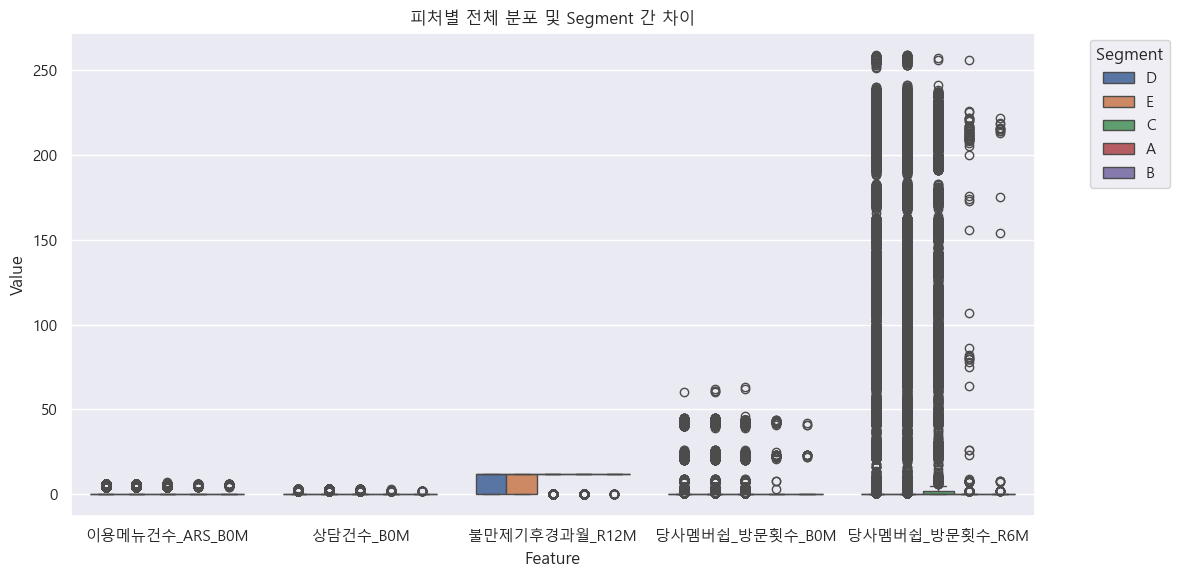

In [10]:
# 분석할 피처 리스트
features = [
    '이용메뉴건수_ARS_B0M',
    '상담건수_B0M',
    '불만제기후경과월_R12M',
    '당사멤버쉽_방문횟수_B0M',
    '당사멤버쉽_방문횟수_R6M'
]

# 세그먼트별 요약 통계(평균·중앙값·표준편차) 계산
summary_stats = (
    df2
    .groupby('Segment')[features]
    .agg(['mean', 'median', 'std'])
    .round(2)
)
print("=== 세그먼트별 요약 통계 ===")
print(summary_stats)

# long-form 데이터로 변환 (시각화용)
df_long = df2.melt(
    id_vars='Segment',
    value_vars=features,
    var_name='Feature',
    value_name='Value'
)

# 박스플롯: 피처별 전체 값 분포와 세그먼트 간 차이
plt.figure(figsize=(12, 6))
sns.boxplot(x='Feature', y='Value', hue='Segment', data=df_long)
plt.title('피처별 전체 분포 및 Segment 간 차이')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 최근 6개월 당사멤버쉽 방문횟수

=== 세그먼트별 요약 통계 ===
          mean  median    std
Segment                      
A        12.63     0.0  48.11
B        17.75     0.0  57.74
C        23.15     0.0  62.03
D        19.66     0.0  58.75
E         9.13     0.0  41.35


<Figure size 600x400 with 0 Axes>

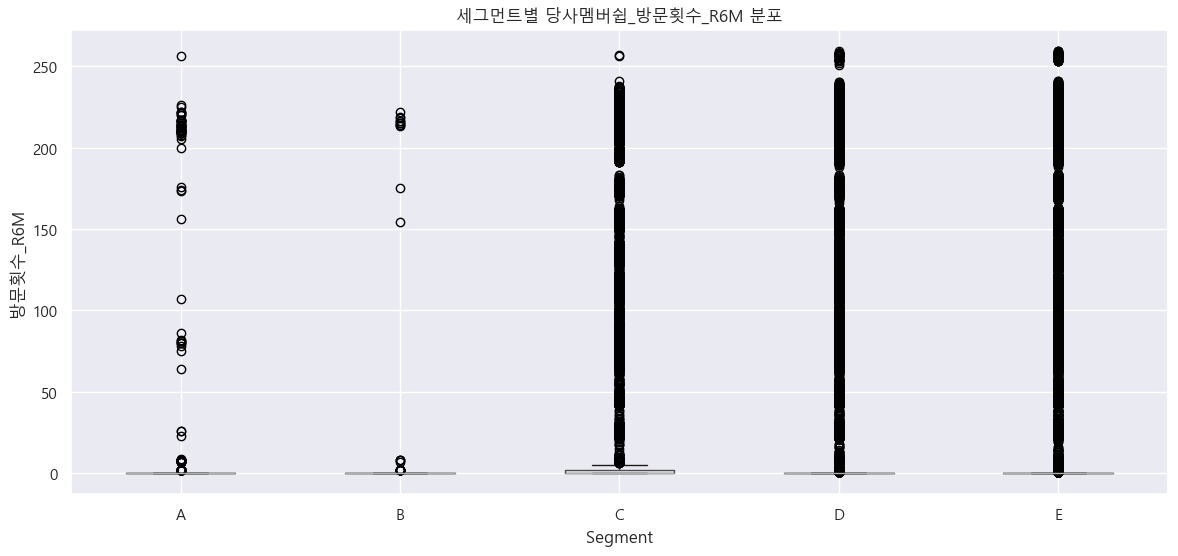

In [11]:
# 세그먼트와 멤버쉽 방문횟수_R6M 컬럼만 선택
data = df2[['Segment', '당사멤버쉽_방문횟수_R6M']]

# 세그먼트별 평균·중앙값·표준편차 구하기
stats = (
    data
    .groupby('Segment')['당사멤버쉽_방문횟수_R6M']
    .agg(['mean', 'median', 'std'])
    .round(2)
)
print("=== 세그먼트별 요약 통계 ===")
print(stats)

# 세그먼트별 분포 박스플롯 그리기
plt.figure(figsize=(6, 4))
data.boxplot(column='당사멤버쉽_방문횟수_R6M', by='Segment')
plt.title('세그먼트별 당사멤버쉽_방문횟수_R6M 분포')
plt.suptitle('')    # 기본 제목 제거
plt.xlabel('Segment')
plt.ylabel('방문횟수_R6M')
plt.tight_layout()
plt.show()

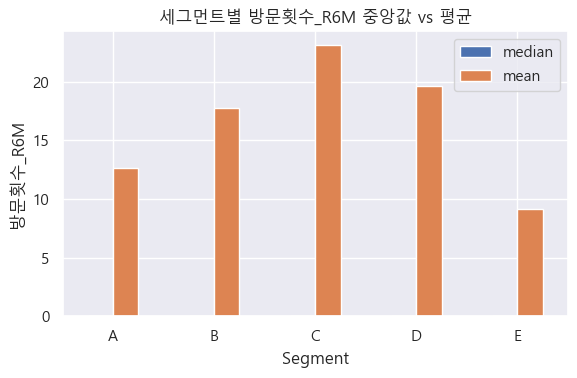

In [12]:
# 요약 통계 계산
stats = df2.groupby('Segment')['당사멤버쉽_방문횟수_R6M'] \
           .agg(['median','mean']) \
           .round(2)

# 바 차트
stats.plot(kind='bar', figsize=(6,4))
plt.title('세그먼트별 방문횟수_R6M 중앙값 vs 평균')
plt.ylabel('방문횟수_R6M')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

<Figure size 600x400 with 0 Axes>

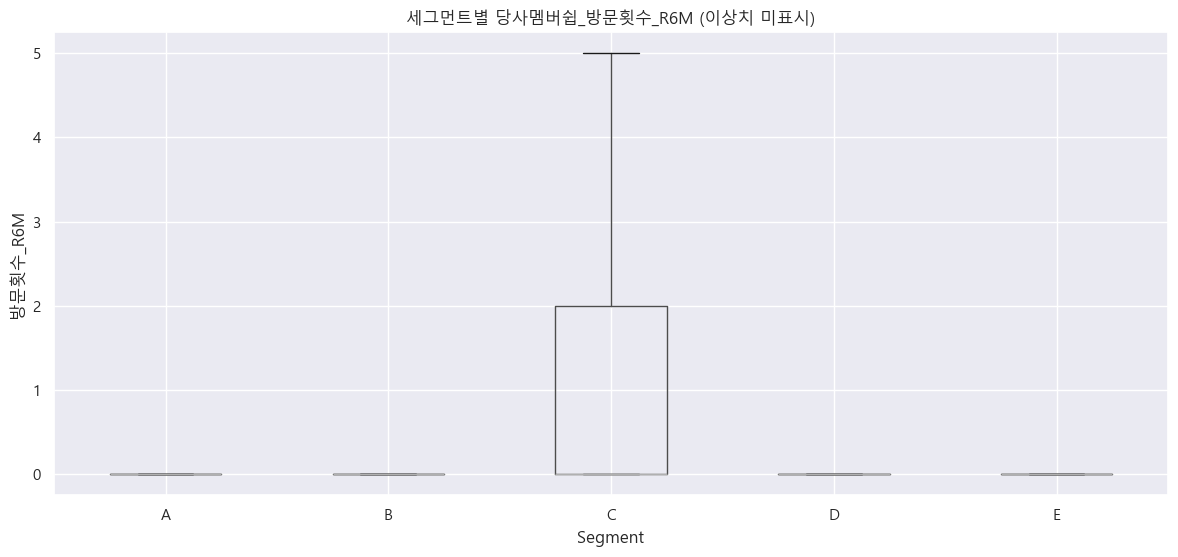

In [13]:
plt.figure(figsize=(6,4))
# fliers=False로 이상치 표시 생략
df2.boxplot(
    column='당사멤버쉽_방문횟수_R6M',
    by='Segment',
    showfliers=False
)
plt.title('세그먼트별 당사멤버쉽_방문횟수_R6M (이상치 미표시)')
plt.suptitle('')
plt.xlabel('Segment')
plt.ylabel('방문횟수_R6M')
plt.tight_layout()
plt.show()

In [14]:
# 이진 변수 생성: 방문횟수_R6M > 0
df2['visits_R6M_positive'] = (df2['당사멤버쉽_방문횟수_R6M'] > 0).astype(int)

# 세그먼트별 비율 확인
print(df2.groupby('Segment')['visits_R6M_positive'].mean().mul(100).round(2))

Segment
A    17.18
B    22.92
C    26.36
D    22.67
E    11.17
Name: visits_R6M_positive, dtype: float64
